In [2]:
import pandas as pd
from nilearn.plotting import plot_design_matrix
from nilearn.image import load_img
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance
import sys
sys.path.append('/home/ubuntu/repos/learning-habits-analysis')
from utils.data import Subject

In [3]:
def load_data(first_lvl_dir, phase, contrast):
    contrast_dir = os.path.join(first_lvl_dir, phase, contrast)
    nii_files = glob.glob(os.path.join(contrast_dir, "*.nii"))
    # sort to have consistent order
    nii_files = sorted(nii_files)
    imgs = [load_img(f) for f in nii_files]
    data = np.stack([img.get_fdata() for img in imgs], axis=-1)
    return data, nii_files

In [4]:
def compare_brain_maps(map1, map2):
    # compute mask
    mask = np.isfinite(map1) & np.isfinite(map2)
    map1_vals = map1[mask]
    map2_vals = map2[mask]
    corr = np.corrcoef(map1_vals.ravel(), map2_vals.ravel())
    return corr[0, 1]

# Reference model: GLM2 (first + second stim pmod)

In [65]:
first_lvl_dir = "/home/ubuntu/data/learning-habits/spm_outputs_noSDC/glm2_combined_2025-11-17-01-52"

contrast= "contrast-02_first_stimxqval"

In [66]:
learning_data, learning_files = load_data(first_lvl_dir, "learning", contrast)
test_data, test_files = load_data(first_lvl_dir, "test", contrast)

In [67]:
corrs = []
for s in range(learning_data.shape[-1]):
    corr = compare_brain_maps(learning_data[...,s], test_data[...,s])
    corrs.append(corr)

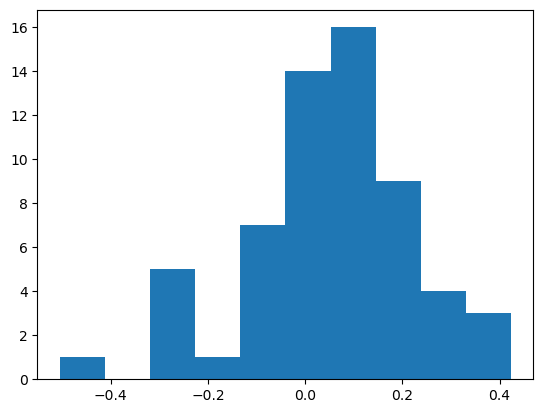

In [8]:
plt.hist(corrs);

# chosen/unchosen pmod

In [38]:
first_lvl_dir = "/home/ubuntu/data/learning-habits/spm_outputs_noSDC/glm2_chosen_2025-11-18-11-32"

contrast= "contrast-03_second_stimxqval_chosen"

In [39]:
learning_data, learning_files = load_data(first_lvl_dir, "learning", contrast)
test_data, test_files = load_data(first_lvl_dir, "test", contrast)

In [40]:
sub_71_idx = [i for i, f in enumerate(test_files) if 'sub-71' in f]
#test_data = np.delete(test_data, sub_71_idx, axis=-1)

In [41]:
corrs = []
for s in range(learning_data.shape[-1]):
    corr = compare_brain_maps(learning_data[...,s], test_data[...,s])
    corrs.append(corr)

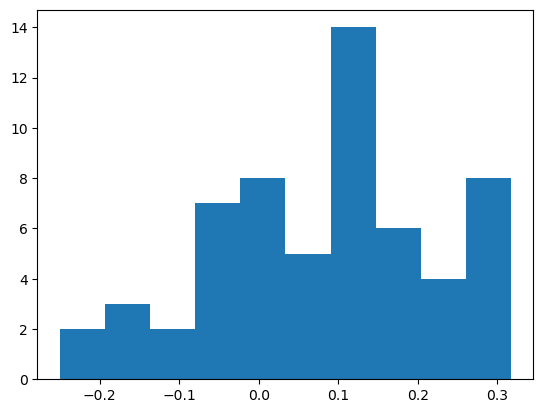

In [42]:
plt.hist(corrs);

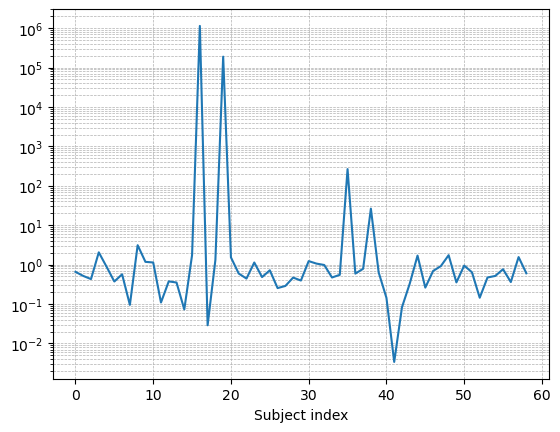

In [49]:
plt.semilogy(np.abs(np.nanmean(learning_data, axis=(0,1,2))))
plt.xlabel('Subject index')
plt.grid(True, which='both', ls='--', lw=0.5)

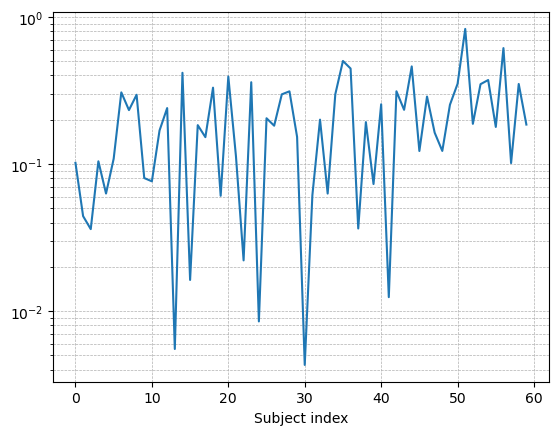

In [50]:
plt.semilogy(np.abs(np.nanmean(test_data, axis=(0,1,2))))
plt.xlabel('Subject index')
plt.grid(True, which='both', ls='--', lw=0.5)

In [31]:
np.where(np.nanmean(learning_data, axis=(0,1,2)) < -1000)

(array([16, 19]),)

In [33]:
learning_files[19]

'/home/ubuntu/data/learning-habits/spm_outputs_noSDC/glm2_chosen_2025-11-18-11-32/learning/contrast-03_second_stimxqval_chosen/_mnt_data_learning-habits_spm_format_nosdc_outputs_glm2_chosen_2025-11-18-11-32_sub-23_learning_desc-second_stimxqval_chosen_con.nii'

# Doing second level using nilearn


In [56]:
from nilearn.glm.second_level import SecondLevelModel
from nilearn.plotting import plot_stat_map

In [71]:
X_RL = pd.DataFrame([1] * learning_data.shape[-1], columns=['RL_value'])

In [72]:
second_level_model_RL = SecondLevelModel()
second_level_model_RL = second_level_model_RL.fit(learning_files, design_matrix=X_RL)

In [73]:
RL_WB_zmap = second_level_model_RL.compute_contrast(output_type='z_score')

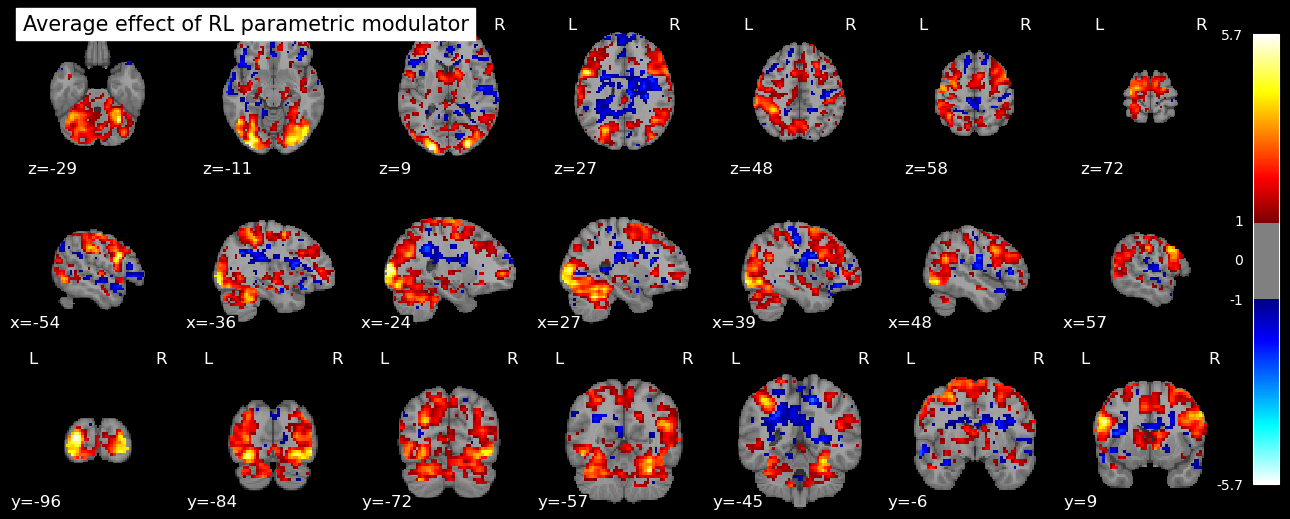

In [74]:
plot_stat_map(RL_WB_zmap, threshold=1, black_bg=True, display_mode='mosaic', title='Average effect of RL parametric modulator')


In [57]:
X_RL = pd.DataFrame([1] * 20, columns=['RL_value'])

In [58]:
second_level_model_RL = SecondLevelModel()
second_level_model_RL = second_level_model_RL.fit(test_files[:20], design_matrix=X_RL)

In [59]:
RL_WB_zmap = second_level_model_RL.compute_contrast(output_type='z_score')

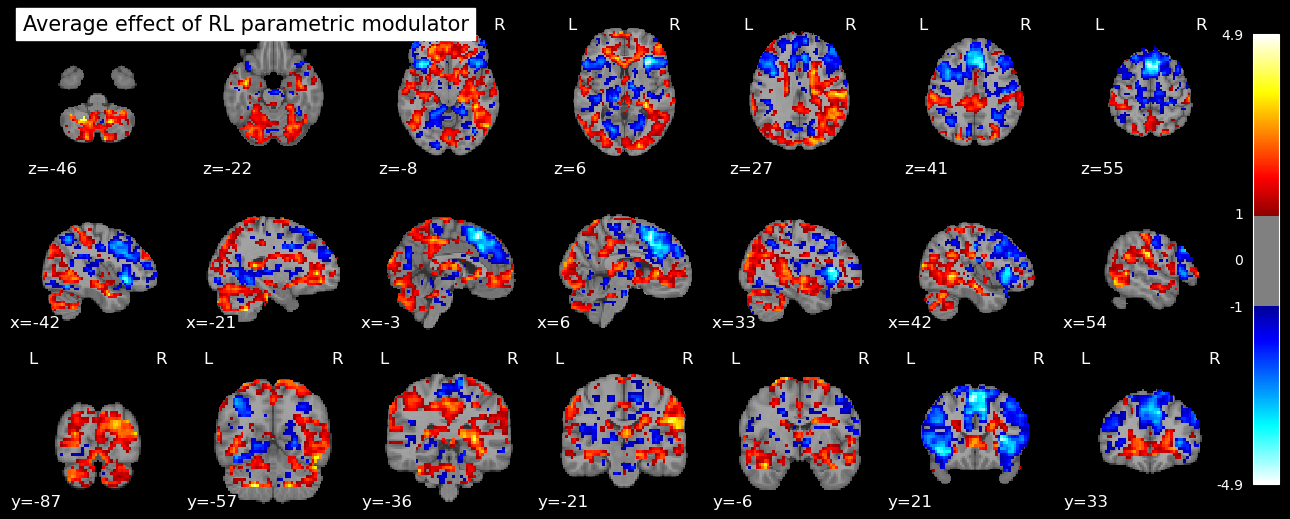

In [60]:
plot_stat_map(RL_WB_zmap, threshold=1, black_bg=True, display_mode='mosaic', title='Average effect of RL parametric modulator')
